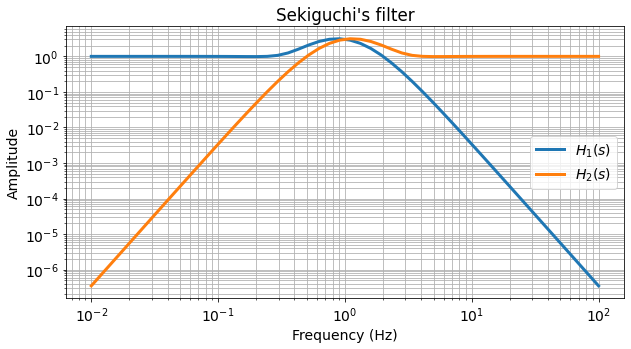

In [2]:
import numpy as np
import control
import matplotlib.pyplot as plt


s = control.tf("s")
H_1_sekiguchi = lambda omega: (35*omega**4*s**3 + 21*omega**5*s**2 + 7*omega**6*s**1 + omega**7)/(s+omega)**7

f_b = 1  # Blend at 1 Hz
H_1 = H_1_sekiguchi(2*np.pi*f_b)
H_2 = 1-H_1

f = np.logspace(-2, 2)

plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 5))
plt.title("Sekiguchi's filter")
plt.loglog(f, abs(H_1(2*np.pi*f*1j)), label="$H_1(s)$", lw=3)
plt.loglog(f, abs(H_2(2*np.pi*f*1j)), label="$H_2(s)$", lw=3)
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")
# plt.savefig("../figures/sekiguchi_complementary_filter.png")
plt.show()


Text(0.5, 0, 'Frequency (Hz)')

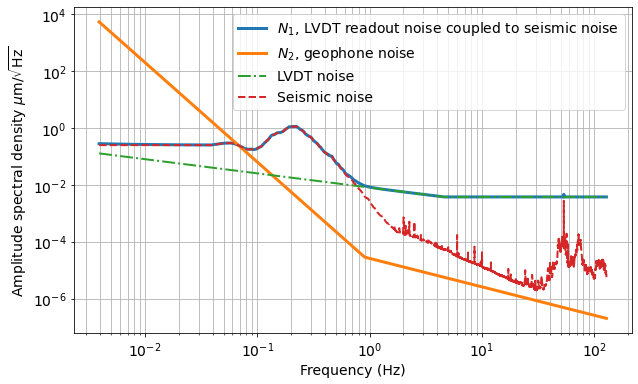

In [3]:
import kontrol.frequency_series.noise_models as noise
import kontrol.core.math


seismic_noise_90_x_data = np.loadtxt("data/X_90_DISP.txt")

f_x, seismic_noise = seismic_noise_90_x_data[:, 0], seismic_noise_90_x_data[:, 1]
for i in range(len(f_x)):
    if f_x[i] < 0.04 and seismic_noise[i]*1e6 > 0.25e-1:
        seismic_noise[i] = 0.25e-6

n1 = kontrol.core.math.quad_sum(noise.lvdt_noise(f_x), seismic_noise*1e6)
n2 = noise.geophone_noise(f_x, n0=2e-5)

plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 6))

plt.loglog(f_x, n1, label="$N_1$, LVDT readout noise coupled to seismic noise", lw=3)
plt.loglog(f_x, n2, label="$N_2$, geophone noise", lw=3)
plt.loglog(f_x, noise.lvdt_noise(f_x), '-.', label="LVDT noise", lw=2)
plt.loglog(f_x, seismic_noise*1e6, '--', label="Seismic noise", lw=2)
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density $\mu \mathrm{m}/\sqrt{\mathrm{Hz}}$")
plt.xlabel("Frequency (Hz)")
# plt.savefig("../figures/sensor_noises_for_complementary_filter.png")

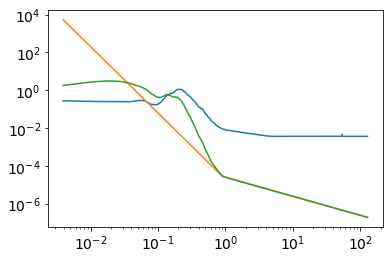

In [4]:
H1 = H_1_sekiguchi(2*np.pi*0.07)
H2 = 1-H1
n1_filtered = abs(H1(2*np.pi*f_x*1j)) * n1
n2_filtered = abs(H2(2*np.pi*f_x*1j)) * n2

n_super = kontrol.core.math.quad_sum(n1_filtered, n2_filtered)
plt.loglog(f_x, n1)
plt.loglog(f_x, n2)
plt.loglog(f_x, n_super)
# fb = res.x[0]
# h1 = H_1_sekiguchi(2*np.pi*fb)
# h2 = 1-h1
# n1_filtered = abs(h1(2*np.pi*f_x*1j)) * n1
# n2_filtered = abs(h2(2*np.pi*f_x*1j)) * n2
# n_super = kontrol.core.math.quad_sum(n1_filtered, n2_filtered)
# plt.loglog(f_x, n_super, "--")
# plt.loglog(f_x, abs(H2(2*np.pi*f_x*1j)))

In [24]:
max(abs(H1(2*np.pi*f_x*1j)))

3.137356424024454

In [25]:
max(abs(H2(2*np.pi*f_x*1j)))

3.1371714370812147

In [5]:
min_n1n2 = [min(n1[i], n2[i]) for i in range(len(n1))]
# np.min(n1, n2)

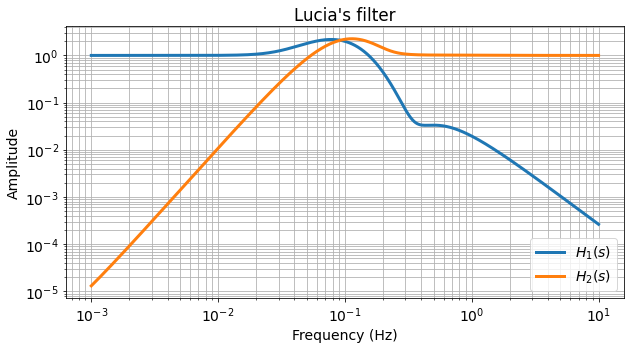

In [28]:
h1_lucia = ((s**2/(0.35*2*np.pi)**2 + 1/(0.35*2*np.pi*2)*s + 1)**1
            *(s**2/(0.35*2*np.pi)**2 + 1/(0.35*2*np.pi*1.1)*s + 1)**1
            *(s**2/(0.031272079*2*np.pi)**2 + 1/(3.127079e-2*2*np.pi*6.44177e-1)*s + 1)
            /(s/0.12/2/np.pi + 1)**5
            / (s/0.25/2/np.pi + 1)**3)
# h1_lucia = (s**2/(0.031272079*2*np.pi)**2 + 1/(3.127079e-2*2*np.pi*6.44177e-1)*s + 1)/(s/0.12/2/np.pi + 1)**5/ (s/0.25/2/np.pi + 1)**3
h2_lucia = 1 - h1_lucia

f = np.logspace(-3,1, 10000)

plt.rcParams["font.size"] = 14
plt.figure(figsize=(10,5))
plt.title("Lucia's filter")
plt.loglog(f, abs(h1_lucia(2*np.pi*f*1j)), label="$H_1(s)$", lw=3)
plt.loglog(f, abs(h2_lucia(2*np.pi*f*1j)), label="$H_2(s)$", lw=3)
# plt.loglog(f_x, n1, "--", label="$\hat{N}_1(f)$", lw=2)
# plt.loglog(f_x, n2, "-.", label="$\hat{N}_2(f)$", lw=2)
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.legend(loc=0)
plt.grid(which="both")
plt.savefig("../figures/lucia_complementary_filter.png")
plt.show()


In [15]:
h1_lucia

TransferFunction(array([0.94442006, 0.28808093, 0.03646183]), array([0.03860764, 0.32748158, 1.19113768, 2.42676672, 3.03095989,
       2.37900115, 1.14750792, 0.31143198, 0.03646183]))

In [59]:
h1_lucia.den[0][0]

array([ 0.90295248,  7.659114  , 27.85823616, 56.75703262, 70.88785585,
       55.63989518, 26.83782654,  7.28374701,  0.85276644])

In [60]:
test = control.tf(h1_lucia.den[0][0][2:], h1_lucia.den[0][0])

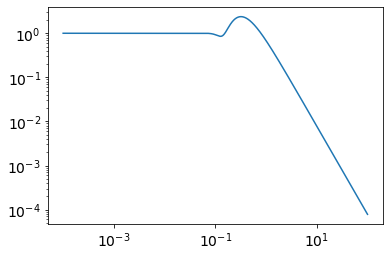

In [64]:
plt.loglog(f, abs(test(2*np.pi*f*1j)))
# plt.loglog(f, abs((1-test)(2*np.pi*f*1j)))

In [66]:
test2 = control.tf(list(h1_lucia.den[0][0][3:])+[0,0,0], h1_lucia.den[0][0])

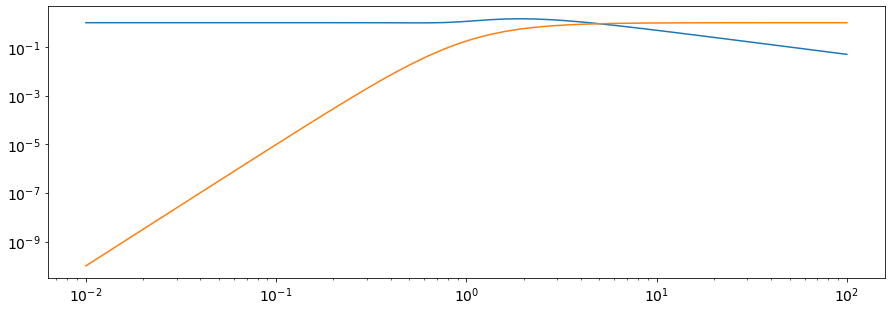

In [82]:
h1 = control.tf(((s+2*np.pi*1)**5).num[0][0][1:],[1])/(s+2*np.pi*1)**5
h2 = 1-h1
f = np.logspace(-2, 2)
plt.figure(figsize=(15,5))
plt.loglog(f, abs(h1(2*np.pi*f*1j)))
plt.loglog(f, abs(h2(2*np.pi*f*1j)))

In [79]:
max(abs(h1(2*np.pi*f*1j)))

1.5552925716055277

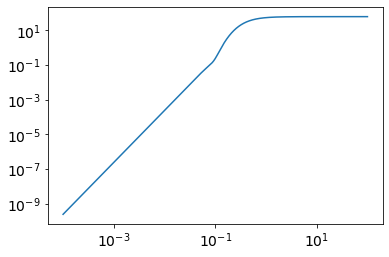

In [68]:
plt.loglog(f, abs(test2(2*np.pi*f*1j)))

In [19]:
max(abs(h1_lucia(2*np.pi*f*1j)))

2.1785294432272444

In [44]:
h2_lucia.zero()

array([-3.29328098+0.j        , -1.81022611+1.49088374j,
       -1.81022611-1.49088374j, -0.71431002+1.28637128j,
       -0.71431002-1.28637128j,  0.076638  +0.j        ,
       -0.05012089+0.j        ,  0.        +0.j        ])